In [68]:
import numpy as np
import subprocess
import os
import vplanet

import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import rc
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)
rc('axes', labelsize=20)
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
try:
    rc('text', usetex=True)
except:
    rc('text', usetex=False)
cmodel = "k"
cdata = "r"

In [2]:
# Star input file template
body_file = """#
sName                     %s          # body name
saModules                 stellar     # VPLanet module(s) used 
dMass                     %.5f        # stellar mass [msun]
dAge                      5e6         # age at which stellar grids are initialized [yr] (this is a fixed parameter)    
sStellarModel             baraffe     # stellar model grid
dSatXUVFrac               %.5f        # fsat = initial Lxuv / Lbol [dimensionless ratio]
dSatXUVTime               %.5f        # tsat = saturation time [yr]
dXUVBeta                  %.5f        # beta = exponential decay rate [dimensionless]

# output evolution parameters
saOutputOrder Time -Luminosity -Radius Temperature -RotPer -LXUVTot RadGyra     
"""

# System input file template
vpl_file = """#
sSystemName               system
iVerbose                  0           # Verbosity level
bOverwrite                1           # Allow file overwrites?
saBodyFiles               %s          # list infile names of all body files (e.g. star.in) 
bDoLog                    1           # Write a log file?
iDigits                   6           # Maximum number of digits to right of decimal
dMinValue                 1e-10       # Minimum value of eccentricity/obliquity
bDoForward                1           # Perform a forward evolution?
bVarDt                    1           # Use variable timestepping?
dEta                      0.01        # Coefficient for variable timestepping

# Input/Output Units
# Units specified in the primary input file are propagated into the bodies
sUnitMass                 solar       # Options: gram, kg, Earth, Neptune, Jupiter, solar
sUnitLength               AU          # Options: cm, m, km, Earth, Jupiter, solar, AU
sUnitTime                 year        # Options: sec, day, year, Myr, Gyr
sUnitAngle                deg         # Options: deg, rad

dStopTime                 %.5f
dOutputTime               1.0e6
"""

In [56]:
def run_stellar(dMass, dSatXUVFrac, dXUVBeta, dSatXUVTime, dStopTime, sSystemName="star", outpath="output"):
    """Run vplanet and collect the output."""
    
    if not os.path.exists(outpath):
        os.mkdir(outpath)
    
    # Write the vpl.in file, substituting in variable inputs
    with open(f"{outpath}/vpl.in", "w") as file:
        saBodyFiles = sSystemName + ".in"
        print(vpl_file % (saBodyFiles, dStopTime), file=file)

    # Write star body file, substituting in variable inputs
    with open(f"{outpath}/{sSystemName}.in", "w") as file:
        print(body_file % (sSystemName, dMass, dSatXUVFrac, dSatXUVTime, dXUVBeta), file=file)
    
    # Execute the model!
    subprocess.call(["vplanet vpl.in"], cwd=outpath, shell=True)

    # if no logfile is found, it is probably because there was something wrong with the infile formatting
    output = vplanet.get_output(outpath)
    body_output = getattr(output, sSystemName)
    
    return body_output

In [88]:
mass = 0.118
fsat = 10**(-2.92)
beta = 1.18
tsat = 3e9
age  = 9e9

evol = run_stellar(mass, fsat, beta, tsat, age, sSystemName="star")

In [89]:
evol.__dict__

{'_name': 'star',
 '_params': [<VPLANETQuantity [0.000e+00, 1.000e+06, 2.000e+06, ..., 8.998e+09,
                    8.999e+09, 9.000e+09] yr>,
  <VPLANETQuantity [0.028529, 0.024865, 0.021927, ..., 0.001426, 0.001426,
                    0.001426] LSUN>,
  <VPLANETQuantity [65.263587, 60.416639, 56.676037, ..., 15.573488,
                    15.573488, 15.573488] earthRad>,
  <VPLANETQuantity [3068.838994, 3082.668963, 3084.150226, ..., 2969.104446,
                    2969.104025, 2969.104025] K>,
  <VPLANETQuantity [ 1.      ,  0.948356,  0.904834, ..., 75.65093 ,
                    75.65636 , 75.661788] days>,
  <VPLANETQuantity [3.423450e-05, 2.983835e-05, 2.631315e-05, ...,
                    4.680708e-07, 4.679577e-07, 4.679575e-07] LSUN>,
  <VPLANETQuantity [0.457823, 0.458848, 0.459654, ..., 0.463486, 0.463486,
                    0.463486]>],
 'name': 'star',
 'infile': 'star.in',
 'fwfile': 'system.star.forward',
 'bwfile': '',
 'climfile': '',
 '_gridparams': [],
 'Time'

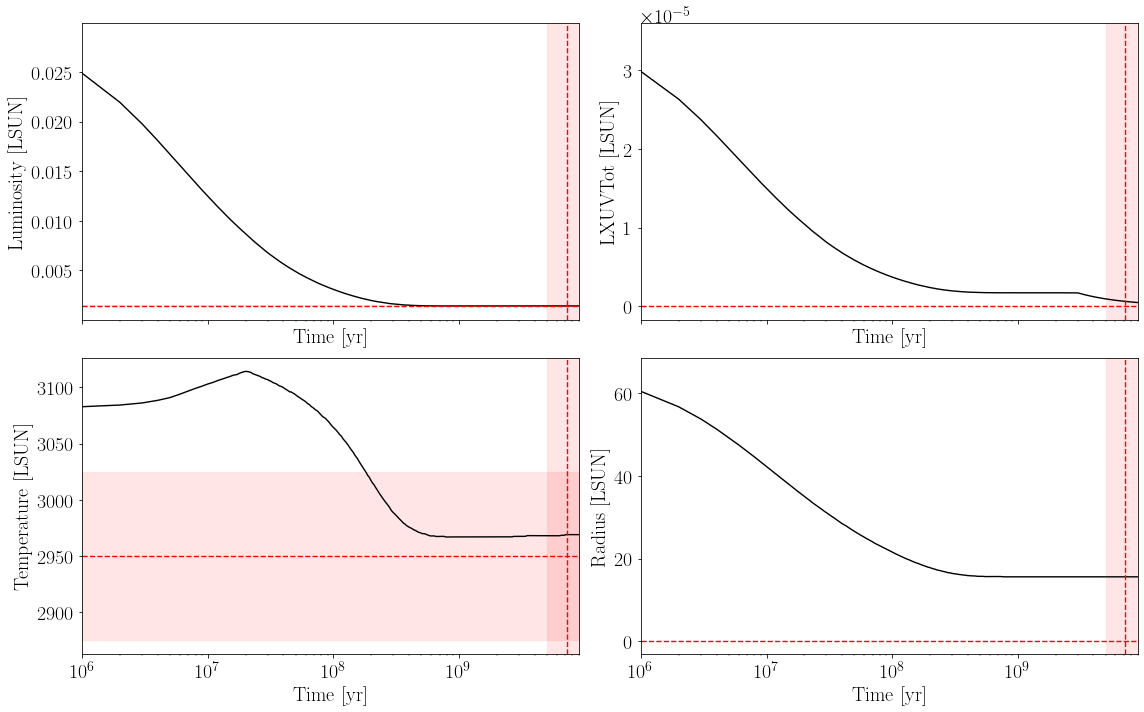

In [106]:
# Observed parameters

lbol = (1.44e-3, 0.04e-3)
lxuv_lbol = (5e-5, 2e-5)
lxuv = (lxuv_lbol[0] * lxuv_lbol[0], 
        lxuv_lbol[0] * lxuv_lbol[0] * np.sqrt(lxuv_lbol[1]**2 + lxuv_lbol[0]**2))

teff = (2950, 75)
rad = (0.1556, 0.0086)
age = (7.2e9, 2.2e9, 3.1e9)

# =========================================================================

plot_params = ["Luminosity", "LXUVTot", "Temperature", "Radius"]

fig, axs = plt.subplots(2, 2, figsize=[16,10], sharex=True)

# -----------------------------------

for ii, ax in enumerate(axs.flatten()):
    
    # Plot evolution models
    ax.plot(evol.Time, getattr(evol, plot_params[ii]), color=cmodel)
    ax.set_ylabel(f"{plot_params[ii]} [{evol.Luminosity.unit}]")
    ax.set_xscale('log')
    # ax.set_yscale('log')

    # Plot age constraint
    ax.axvline(age[0], linestyle='--', color=cdata)
    ax.axvspan(age[0]-age[1], age[0]+age[2], color=cdata, alpha=.1)

# -----------------------------------
# Plot observational constraints

axs[0][0].axhline(lbol[0], linestyle='--', color=cdata)
axs[0][0].axhspan(lbol[0]-lbol[1], lbol[0]+lbol[1], color=cdata, alpha=.1)

axs[0][1].axhline(lxuv[0], linestyle='--', color=cdata)
axs[0][1].axhspan(lxuv[0]-lxuv[1], lxuv[0]+lxuv[1], color=cdata, alpha=.1)

axs[1][0].axhline(teff[0], linestyle='--', color=cdata)
axs[1][0].axhspan(teff[0]-teff[1], teff[0]+teff[1], color=cdata, alpha=.1)

axs[1][1].axhline(rad[0], linestyle='--', color=cdata)
axs[1][1].axhspan(rad[0]-rad[1], rad[0]+rad[1], color=cdata, alpha=.1)

plt.xlim(evol.Time[1], evol.Time[-1])
plt.show()